In [2]:
import sys
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold
import pm4py
import seaborn as sns
import math
import matplotlib.pyplot as plt

/usr/local/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Data Preparation

In [3]:
def read_and_prep_dataset(file_path):
    # read dataset
    data_raw = pm4py.read_xes(file_path)
        
    # Let's only consider the complete lifecycle:transition, this is because the value "complete" meaning
    # the ongoing single event task is finished instead of being suspended or withdrawal, increasing the possibility to
    # get more complete traces for our prediction
    data_raw = data_raw[data_raw['lifecycle:transition'] == 'complete']
    log = pm4py.convert_to_event_log(data_raw)
        
    # Only keep two most frequent traces, we believe these are the most complete traces
    filtered_log = pm4py.filter_end_activities(log, ['A_Pending','O_Cancelled'])
        
    df = pm4py.convert_to_dataframe(filtered_log)
    agg_dict = {"time:timestamp" :['min', 'max']}
    duration_df = pd.DataFrame(df.groupby("case:concept:name").agg(agg_dict)).reset_index()
    duration_df["trace_duration_days"] = (duration_df[("time:timestamp","max")] - duration_df[("time:timestamp","min")]).dt.total_seconds() / (24 * 60 * 60)
    duration_df['trace_duration_days'] = duration_df['trace_duration_days'].apply(lambda x: math.ceil(x))
    duration_df["trace_duration_seconds"] = (duration_df[("time:timestamp","max")] - duration_df[("time:timestamp","min")]).dt.total_seconds()
    duration_df.drop(columns=['time:timestamp'],inplace=True)
    duration_df = duration_df.droplevel(1, axis=1)

    df_with_duration = df.merge(duration_df, on='case:concept:name')
    #df_with_duration['sum_Time_sec'] = df.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x - x.iloc[0]).dt.total_seconds()
    df_with_duration_remain = df_with_duration.copy()
    df_with_duration_remain['remaining_time_seconds'] = df_with_duration.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.iloc[-1] - x).dt.total_seconds()
    df_with_duration_remain['remaining_time_days'] = df_with_duration.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.iloc[-1] - x).dt.total_seconds() / (24 * 60 * 60)
    df_with_duration_remain['remaining_time_days'] = df_with_duration_remain['remaining_time_days'].apply(lambda x: math.ceil(x))
    
    
    #df_with_duration_remain['Complete_Timestamp'] = df_with_duration_remain.groupby('case:concept:name')['time:timestamp'].transform('last')
    #df_with_duration['duration'] = df_with_duration.groupby('case:concept:name')['time:timestamp'].diff().dt.total_seconds()
        
    return df_with_duration_remain, log
# Duration time, remaining_time cannot be used for testing, just for knowing data distribution

In [4]:
data,raw = read_and_prep_dataset('BPI_Challenge_2017.xes.gz')

/usr/local/lib/python3.9/site-packages/pm4py/util/dt_parsing/parser.py:77: UserWarning: ISO8601 strings are not fully supported with strpfromiso for Python versions below 3.11
  warnings.warn(


parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/pm4py/utils.py:537: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/var/folders/1k/g6jpvmcs1cxb7t87t60d7dy40000gn/T/ipykernel_68205/3488970716.py:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  duration_df.drop(columns=['time:timestamp'],inplace=True)


In [5]:
data


,Action,org:resource,concept:name,EventOrigin,EventID,lifecycle:transition,time:timestamp,FirstWithdrawalAmount,NumberOfTerms,Accepted,...,OfferedAmount,OfferID,case:LoanGoal,case:ApplicationType,case:concept:name,case:RequestedAmount,trace_duration_days,trace_duration_seconds,remaining_time_seconds,remaining_time_days
0,Created,User_1,A_Create Application,Application,Application_652823628,complete,2016-01-01 09:51:15.304000+00:00,NaN,NaN,NaN,...,NaN,NaN,Existing loan takeover,New credit,Application_652823628,20000.0,14,1144676.116,1144676.116,14
1,statechange,User_1,A_Submitted,Application,ApplState_1582051990,complete,2016-01-01 09:51:15.352000+00:00,NaN,NaN,NaN,...,NaN,NaN,Existing loan takeover,New credit,Application_652823628,20000.0,14,1144676.116,1144676.068,14
2,statechange,User_1,A_Concept,Application,ApplState_642383566,complete,2016-01-01 09:52:36.413000+00:00,NaN,NaN,NaN,...,NaN,NaN,Existing loan takeover,New credit,Application_652823628,20000.0,14,1144676.116,1144595.007,14
3,statechange,User_52,A_Accepted,Application,ApplState_99568828,complete,2016-01-02 11:23:04.299000+00:00,NaN,NaN,NaN,...,NaN,NaN,Existing loan takeover,New credit,Application_652823628,20000.0,14,1144676.116,1052767.121,13
4,Created,User_52,O_Create Offer,Offer,Offer_148581083,complete,2016-01-02 11:29:03.994000+00:00,20000.0,44.0,True,...,20000.0,NaN,Existing loan takeover,New credit,Application_652823628,20000.0,14,1144676.116,1052407.426,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363341,statechange,User_96,O_Sent (mail and online),Offer,OfferState_1959881309,complete,2017-01-02 19:27:20.453000+00:00,NaN,NaN,NaN,...,NaN,Offer_1580299144,Home improvement,New credit,Application_1350494635,20000.0,16,1340007.923,1175040.686,14
363342,Deleted,User_96,W_Complete application,Workflow,Workitem_22300685,complete,2017-01-02 19:27:20.465000+00:00,NaN,NaN,NaN,...,NaN,NaN,Home improvement,New credit,Application_1350494635,20000.0,16,1340007.923,1175040.674,14
363343,statechange,User_96,A_Complete,Application,ApplState_1120616436,complete,2017-01-02 19:27:20.474000+00:00,NaN,NaN,NaN,...,NaN,NaN,Home improvement,New credit,Application_1350494635,20000.0,16,1340007.923,1175040.665,14
363344,statechange,User_28,A_Cancelled,Application,ApplState_1869071797,complete,2017-01-16 09:51:21.114000+00:00,NaN,NaN,NaN,...,NaN,NaN,Home improvement,New credit,Application_1350494635,20000.0,16,1340007.923,0.025,1


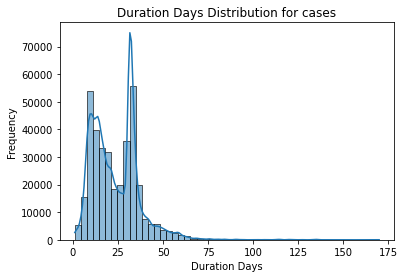

In [6]:
sns.histplot(data['trace_duration_days'],bins=50, kde=True)
plt.title('Duration Days Distribution for cases')
plt.xlabel('Duration Days')
plt.ylabel('Frequency')
plt.show()

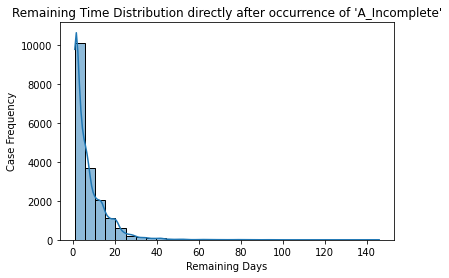

In [7]:

selected_rows_A_Incomplete = data[data['concept:name'] == 'A_Incomplete']



sns.histplot(selected_rows_A_Incomplete['remaining_time_days'], bins=30, kde=True)
plt.title('Remaining Time Distribution directly after occurrence of \'A_Incomplete\'')
plt.xlabel('Remaining Days')
plt.ylabel('Case Frequency')
plt.show()

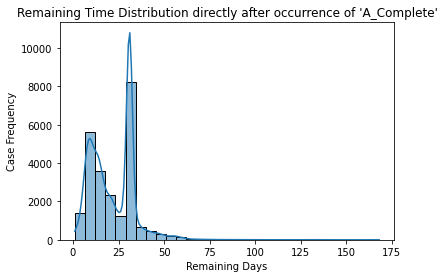

In [8]:

selected_rows_A_Complete = data[data['concept:name'] == 'A_Complete']



sns.histplot(selected_rows_A_Complete['remaining_time_days'], bins=30, kde=True)
plt.title('Remaining Time Distribution directly after occurrence of \'A_Complete\'')
plt.xlabel('Remaining Days')
plt.ylabel('Case Frequency')
plt.show()

In [9]:
def find_order_Event(act, df):
    # Extract cases containing the specified activity
    matching_cases = df[(df['concept:name'] == act)]['case:concept:name']

    # Filter rows that meet the condition
    result_df = df[df['case:concept:name'].isin(matching_cases)]

    # Sort the DataFrame by time and case
    result_df = result_df.sort_values(by=['case:concept:name', 'time:timestamp'])

    # Add order numbers for each occurrence of the specified activity
    result_df[f'{act}_Order'] = result_df[result_df['concept:name'] == act].groupby('case:concept:name').cumcount() + 1

    # Rename occurrences of the specified activity based on order number
    result_df['concept:name'] = result_df.apply(lambda row: f"{act}_{int(row[f'{act}_Order'])}" 
                                              if row['concept:name'] == act else row['concept:name'], 
                                              axis=1)

    # Drop the 'A_Incomplete_Order' column (if needed)
    result_df = result_df.drop(f'{act}_Order', axis=1)
    
    return result_df

In [10]:
df_A_Incomplete = find_order_Event('A_Incomplete',data)

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [12]:
def plot_distribution(df, act, rows, num):

    # Assume your DataFrame is df, 'remaining_time_days' represents remaining time, 'concept:name' represents activity
    # Replace 'remaining_time_days' and 'concept:name' with your actual column names

    # Select rows for the specified activity, ranging from 1 to num
    selected_rows = df[df['concept:name'].isin([f'{act}_{i}' for i in range(1, num+1)])]

    # Calculate the number of rows and columns
    cols = math.ceil(len(selected_rows['concept:name'].unique()) / rows)

    if cols == 1:
        # Use seaborn's distplot to plot the histogram and curve
        sns.histplot(data=selected_rows, x='remaining_time_days', bins=25, kde=True, color='red')
        plt.title(f'Remaining Time Distribution after the occurrence of {act}')
        plt.xlabel('Remaining Days')
        plt.ylabel('Case Frequency')

    else:
        # Get the range of x-axis for all subplots
        x_axis_range = selected_rows['remaining_time_days'].max()

        # Set up subplot layout
        fig, axes = plt.subplots(rows, cols, figsize=(13, 12))

        # Plot multiple subplots together and set the same x-axis range
        for i, (activity, group) in enumerate(selected_rows.groupby('concept:name')):
            ax = axes[i // cols, i % cols]
            sns.histplot(data=group, x='remaining_time_days', bins=25, kde=True, ax=ax, color='red', line_kws={'color': 'orange', 'linewidth': 3})
            text_dict = {0: 'first', 1: 'second', 2: 'third', 3: 'fourth', 4: 'fifth', 5: 'sixth'}
            ax.set_title('Remaining Time Distribution after the ' + text_dict[i] + ' occurrence of ' + act)
            ax.set_xlabel('Remaining Days')
            ax.set_ylabel('Case Frequency')
            ax.set_xlim(0, x_axis_range)  # Set the same x-axis range

    # Adjust layout
    plt.tight_layout()
    plt.show()


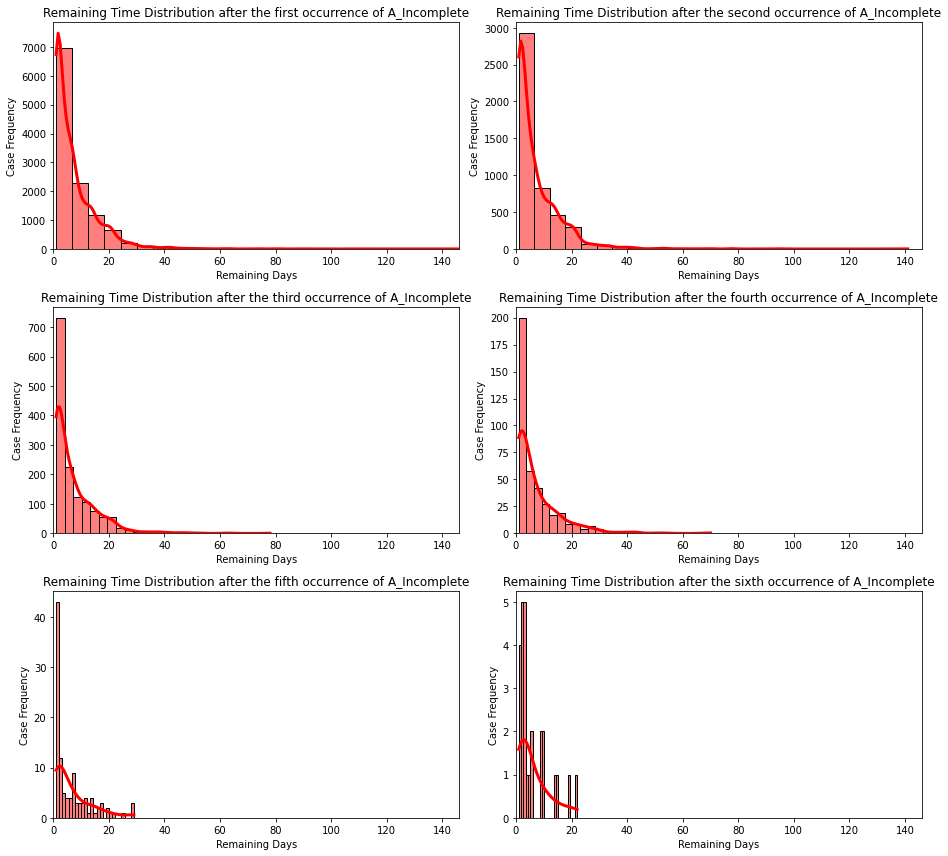

In [13]:
plot_distribution(df_A_Incomplete,'A_Incomplete',3,6)

In [14]:
df_A_Complete = find_order_Event('A_Complete',data)

In [15]:
df_O_Accepted=find_order_Event('O_Accepted',data)
df_W_Call_incomplete_filese=find_order_Event('W_Call incomplete files',data)
df_W_Complete_application=find_order_Event('W_Complete application',data)

In [16]:
df_A_Complete.remaining_time_seconds

198744    2815395.156
198745    2815395.095
198746    2815328.530
198747    2649809.410
198748    2649639.509
             ...     
274713     417385.227
274714     417378.572
274715     409200.767
274716          0.003
274717          0.000
Name: remaining_time_seconds, Length: 362861, dtype: float64

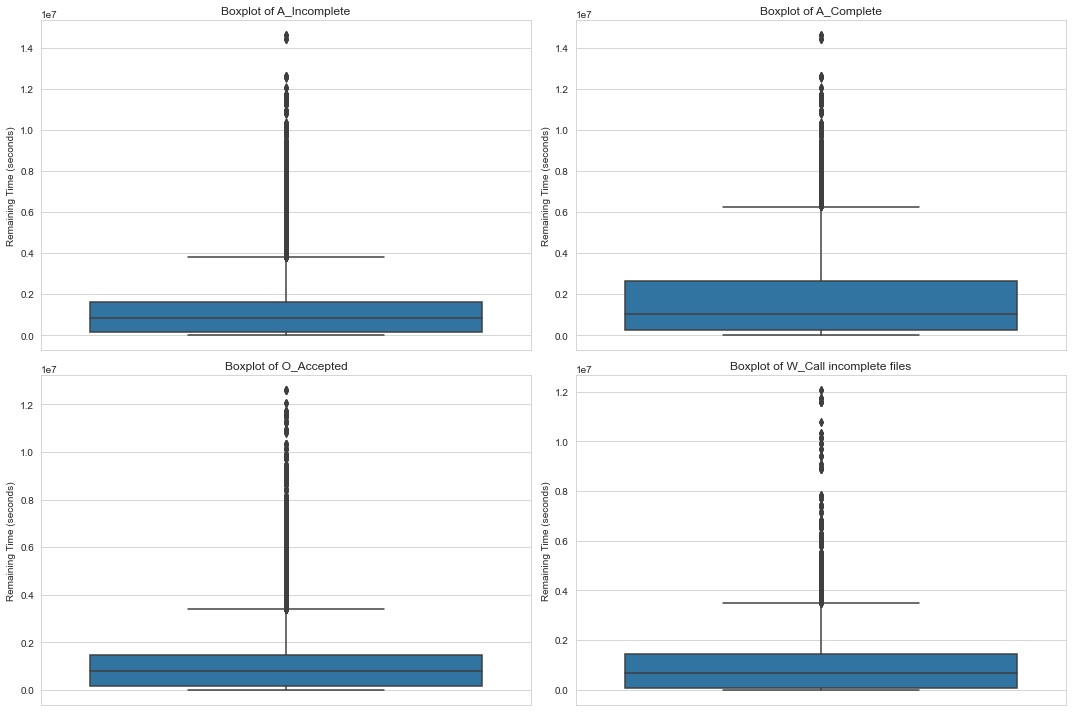

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set_style('whitegrid')

# Define the number of subplots based on how many DataFrames you want to plot
# In this case, we have 4 DataFrames
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))  # Adjust nrows and ncols as needed

# Create boxplot for each DataFrame
sns.boxplot(data=df_A_Incomplete, y='remaining_time_seconds', ax=axes[0, 0])
axes[0, 0].set_title('Boxplot of A_Incomplete')
axes[0, 0].set_ylabel('Remaining Time (seconds)')

sns.boxplot(data=df_A_Complete, y='remaining_time_seconds', ax=axes[0, 1])
axes[0, 1].set_title('Boxplot of A_Complete')
axes[0, 1].set_ylabel('Remaining Time (seconds)')

sns.boxplot(data=df_O_Accepted, y='remaining_time_seconds', ax=axes[1, 0])
axes[1, 0].set_title('Boxplot of O_Accepted')
axes[1, 0].set_ylabel('Remaining Time (seconds)')

sns.boxplot(data=df_W_Call_incomplete_filese, y='remaining_time_seconds', ax=axes[1, 1])
axes[1, 1].set_title('Boxplot of W_Call incomplete files')
axes[1, 1].set_ylabel('Remaining Time (seconds)')

# Adjust the layout
plt.tight_layout()
plt.show()



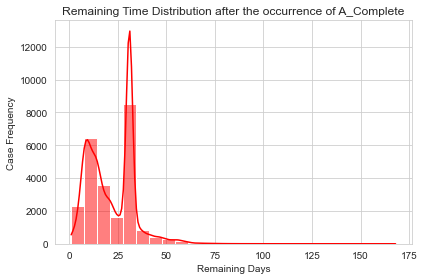

In [18]:
plot_distribution(df_A_Complete,'A_Complete',1,1)

In [19]:
df_O_Returned = find_order_Event('O_Returned',data)

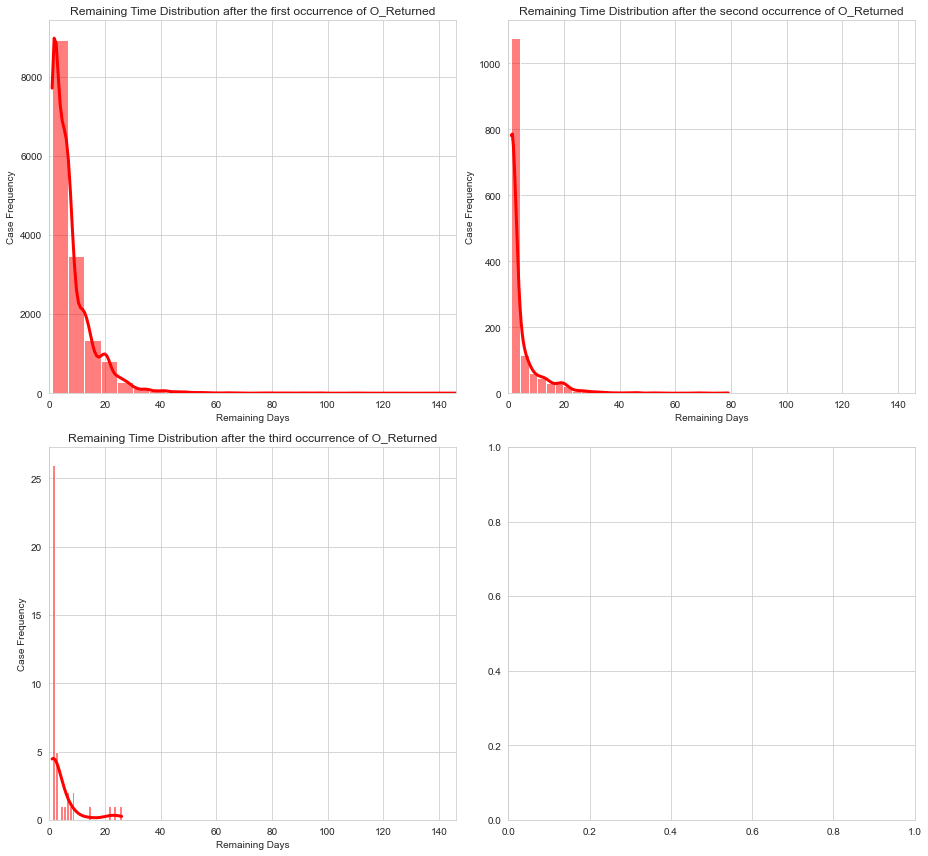

In [20]:
plot_distribution(df_O_Returned,'O_Returned',2,3)

# Feature Selection and Encoding

In [21]:
all_act=['concept:name_A_Create Application', 'concept:name_A_Submitted', 'concept:name_A_Concept', 'concept:name_A_Accepted',
       'concept:name_O_Create Offer', 'concept:name_O_Created', 'concept:name_O_Sent (mail and online)',
       'concept:name_A_Complete', 'concept:name_A_Validating', 'concept:name_O_Returned', 'concept:name_A_Incomplete',
       'concept:name_O_Accepted', 'concept:name_A_Pending', 'concept:name_W_Complete application', 'concept:name_O_Cancelled',
       'concept:name_W_Handle leads', 'concept:name_W_Validate application', 'concept:name_A_Cancelled',
       'concept:name_O_Sent (online only)', 'concept:name_W_Call incomplete files',
       'concept:name_W_Call after offers', 'concept:name_W_Assess potential fraud']

In [22]:
case_id_col = 'case:concept:name'
y_col = 'remaining_time_seconds'
dynamic_cat_cols = ['concept:name','Action','Selected','Accepted','org:resource']
static_cat_cols = ['case:LoanGoal']
dynamic_num_cols = ['FirstWithdrawalAmount','NumberOfTerms',
                                 'OfferedAmount','MonthlyCost']
static_num_cols = ['case:RequestedAmount']

# cat_cols = dynamic_cat_cols + static_cat_cols
# num_cols = dynamic_num_cols + static_num_cols

In [23]:
df_static = data[static_cat_cols + static_num_cols + ['case:concept:name']].drop_duplicates(keep='last')

In [24]:
def AggregateTransformer(X, case_id_col, num_cols, cat_cols, all_activities):
    # Ensure concept:name is in cat_cols for dummy variable creation
    if 'concept:name' not in cat_cols:
        cat_cols.append('concept:name')

    # Transform numeric columns
    dt_numeric = pd.DataFrame()
    if len(num_cols) > 0:
        dt_numeric = X.groupby(case_id_col)[num_cols].agg(["mean", "max", "min", "sum"])
        dt_numeric.columns = ['_'.join(col).strip() for col in dt_numeric.columns.values]

    # Transform categorical columns - creating dummy variables
    dt_cat = pd.get_dummies(X[cat_cols])
    dt_cat[case_id_col] = X[case_id_col]

    # Group by case_id_col and sum to get count of each activity per case
    dt_cat_grouped = dt_cat.groupby(case_id_col).sum()

    # Add missing activity columns with 0 values
    missing_activities = set(all_activities) - set(dt_cat_grouped.columns)
    for activity in missing_activities:
        dt_cat_grouped[activity] = 0

    # Concatenate numeric and categorical data
    dt_transformed = pd.concat([dt_cat_grouped, dt_numeric], axis=1)

    # Fill missing values with 0
    dt_transformed.fillna(0, inplace=True)
    
    return dt_transformed

# Bucketing and Prediction

In [25]:
data.drop(columns=['trace_duration_seconds','trace_duration_days'],inplace=True)

In [26]:
train_df, test_df = pm4py.split_train_test(data, train_percentage=0.75)

In [27]:
def get_bucket(act, df, num):
    # Sort the DataFrame by time and case
    df = df.sort_values(by=['case:concept:name', 'time:timestamp'])

    # Find the first indices where 'act_num' appears in each case
    first_indices = df[df['concept:name'] == f'{act}_{num}'].groupby('case:concept:name').head(1).index

    # Process each case
    result_dfs = []
    for case_name, case_group in df.groupby('case:concept:name'):
        # Find the first index where 'act_num' appears in the current case
        current_case_first_index = first_indices[first_indices.isin(case_group.index)]

        # Create a boolean mask identifying rows in the current case before the first occurrence of 'act_num'
        keep_rows_mask = case_group.index <= current_case_first_index.min()

        # Use the mask to filter out the rows to be kept and add them to the result set
        result_df = case_group[keep_rows_mask]
        result_dfs.append(result_df)

    # Concatenate the result set into a single DataFrame
    result_df = pd.concat(result_dfs)

    return result_df


In [28]:
#function to get labels ready
def get_y(df_y, case_id_col):
 
    df_= df_y.groupby(case_id_col)['remaining_time_days'].last().reset_index()
    Y=df_['remaining_time_days']

    return Y

In [29]:
#get bucket for A_Incomplete_1

bucket_train_A_Incomplete = get_bucket('A_Incomplete',find_order_Event('A_Incomplete',train_df),1)
bucket_test_A_Incomplete = get_bucket('A_Incomplete',find_order_Event('A_Incomplete',test_df),1)

In [30]:
#encode activities
bucket_train_A_Incomplete_encoded = AggregateTransformer(bucket_train_A_Incomplete,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols, all_activities=all_act)
bucket_test_A_Incomplete_encoded = AggregateTransformer(bucket_test_A_Incomplete,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols, all_activities=all_act)

In [31]:
#get bucket for A_Complete
bucket_train_A_Complete = get_bucket('A_Complete',find_order_Event('A_Complete',train_df),1)
bucket_test_A_Complete = get_bucket('A_Complete',find_order_Event('A_Complete',test_df),1)

In [32]:
bucket_train_A_Complete_encoded = AggregateTransformer(bucket_train_A_Complete,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols, all_activities=all_act)
bucket_test_A_Complete_encoded = AggregateTransformer(bucket_test_A_Complete,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols, all_activities=all_act)

### Every trace only have one A_Complete

In [33]:
#get bucket for O_Returned_1
bucket_train_O_Returned = get_bucket('O_Returned',find_order_Event('O_Returned',train_df),1)
bucket_test_O_Returned = get_bucket('O_Returned',find_order_Event('O_Returned',test_df),1)

### Change 1 to 2 or 3 can get buckets maintaing until the second, third occurence of O_Returned

In [34]:
bucket_train_O_Returned_encoded = AggregateTransformer(bucket_train_O_Returned,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols, all_activities=all_act)
bucket_test_O_Returned_encoded = AggregateTransformer(bucket_test_O_Returned,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols, all_activities=all_act)

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [36]:
def get_train_test_bucket(train,test,train_encoded,test_encoded):
        
    df_train = pd.DataFrame(train_encoded)
    df_train = pd.merge(df_train, df_static, how='left',on='case:concept:name').drop(columns=['case:concept:name'])
    string_columns = df_train.select_dtypes(include=['object']).columns
    df_train_encoded = pd.get_dummies(df_train, columns=string_columns)

    Y_train = get_y(train,case_id_col)

    df_test = pd.DataFrame(test_encoded)
    df_test = pd.merge(df_test, df_static, how='left',on='case:concept:name').drop(columns=['case:concept:name'])
    df_test_encoded = pd.get_dummies(df_test, columns=string_columns)

    intersection = list(set(df_train_encoded.columns).intersection(df_test_encoded.columns))
    df_train_encoded = df_train_encoded[intersection]
    df_test_encoded = df_test_encoded[intersection]

    Y_test = get_y(test, case_id_col)
    
    return df_train_encoded, df_test_encoded, Y_train, Y_test

In [37]:
df_train_encoded, df_test_encoded, Y_train, Y_test = get_train_test_bucket(bucket_train_O_Returned,
                                                                           bucket_test_O_Returned,
                                                                          bucket_train_O_Returned_encoded,
                                                                          bucket_test_O_Returned_encoded)

# Try for other buckets

In [38]:
def test_equal(df1, df2):
    train,test=[],[]
    for i in range(len(df1.columns)):
        train.append(df1.columns[i])
        test.append(df2.columns[i])

    print(train==test)

In [42]:
def baseline(df):
    df['elapsed_time_seconds'] = df.groupby('case:concept:name')['time:timestamp'].transform(lambda x: (x - x.min()).dt.total_seconds())
    df['elapsed_time_seconds'] = df.groupby('case:concept:name')['time:timestamp'].transform(lambda x: (x - x.min()).dt.total_seconds())
    # Calculate the average total duration of a case from the training set
    y_total = df['remaining_time_seconds'].mean()

    # Calculate the remaining time for each case in the training set
    df['predicted_remaining_time'] = y_total - df['elapsed_time_seconds']

    # To evaluate the performance, we can use mean absolute error
    # between the actual remaining times and the predicted remaining times
    actual_remaining_times = df['remaining_time_seconds']
    predicted_remaining_times = df['predicted_remaining_time']
    mae = mean_absolute_error(actual_remaining_times, predicted_remaining_times)
    return y_total,mae/86400

### O_returned bucket

In [144]:
print('The MAE of the naïve model: ',baseline(bucket_test_O_Returned)[1])

The MAE of the naïve model:  8.372997969522464


In [39]:
test_equal(df_train_encoded,df_test_encoded)

True


In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

#create and train random forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(df_train_encoded, Y_train )

RandomForestRegressor(random_state=42)

In [41]:
#make predictions
y_pred = rf_model.predict(df_test_encoded)

# Calculate and print the errors
mse = mean_squared_error(Y_test, y_pred)
mae = mean_absolute_error(Y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 55.17857408511094
Mean Absolute Error: 4.90568220038945


### A_complete

In [44]:
df_train_encoded_complete, df_test_encoded_complete, Y_train_complete, Y_test_complete = get_train_test_bucket(bucket_train_A_Complete,
                                                                           bucket_test_A_Complete,
                                                                          bucket_train_A_Complete_encoded,
                                                                          bucket_test_A_Complete_encoded)


In [145]:
print('The MAE of the naïve model: ',baseline(bucket_test_A_Complete)[1])

The MAE of the naïve model:  10.68301078355624


In [46]:
test_equal(df_train_encoded_complete,df_test_encoded_complete)

True


In [47]:
#Create and test model
rf_model1 = RandomForestRegressor(random_state=42)
rf_model1.fit(df_train_encoded_complete, Y_train_complete )

#make prediction
y_pred = rf_model1.predict(df_test_encoded_complete)

# Calculate and print the errors
mse = mean_squared_error(Y_test_complete, y_pred)
mae = mean_absolute_error(Y_test_complete, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 114.03515589483642
Mean Absolute Error: 7.511470601974509


## A_Incomplete

In [48]:
df_train_encoded_incomplete, df_test_encoded_incomplete, Y_train_incomplete, Y_test_incomplete = get_train_test_bucket(bucket_train_A_Incomplete,
                                                                           bucket_test_A_Incomplete,
                                                                          bucket_train_A_Incomplete_encoded,
                                                                          bucket_test_A_Incomplete_encoded)


In [146]:
print('The MAE of the naïve model: ',baseline(bucket_test_A_Incomplete)[1])

The MAE of the naïve model:  8.97797479469575


In [50]:
test_equal(df_train_encoded_incomplete,df_test_encoded_incomplete)

True


In [51]:
#create and train model
rf_model2 = RandomForestRegressor(random_state=42)
rf_model2.fit(df_train_encoded_incomplete, Y_train_incomplete )

#make predictions
y_pred = rf_model2.predict(df_test_encoded_incomplete)

# Calculate and print the errors
mse = mean_squared_error(Y_test_incomplete, y_pred)
mae = mean_absolute_error(Y_test_incomplete, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 61.87492730459165
Mean Absolute Error: 5.327711181212758


## Raw data

In [59]:
def read_and_prep_dataset2(file_path):
    # read dataset
    data_raw = pm4py.read_xes(file_path)
        
    # Let's only consider the complete lifecycle:transition, this is because the value "complete" meaning
    # the ongoing single event task is finished instead of being suspended or withdrawal, increasing the possibility to
    # get more complete traces for our prediction
    data_raw = data_raw[data_raw['lifecycle:transition'] == 'complete']
    log = pm4py.convert_to_event_log(data_raw)
        
    # Only keep two most frequent traces, we believe these are the most complete traces
    
        
    df = pm4py.convert_to_dataframe(log)
    agg_dict = {"time:timestamp" :['min', 'max']}
    duration_df = pd.DataFrame(df.groupby("case:concept:name").agg(agg_dict)).reset_index()
    duration_df["trace_duration_days"] = (duration_df[("time:timestamp","max")] - duration_df[("time:timestamp","min")]).dt.total_seconds() / (24 * 60 * 60)
    duration_df['trace_duration_days'] = duration_df['trace_duration_days'].apply(lambda x: math.ceil(x))
    duration_df["trace_duration_seconds"] = (duration_df[("time:timestamp","max")] - duration_df[("time:timestamp","min")]).dt.total_seconds()
    duration_df.drop(columns=['time:timestamp'],inplace=True)
    duration_df = duration_df.droplevel(1, axis=1)

    df_with_duration = df.merge(duration_df, on='case:concept:name')
    #df_with_duration['sum_Time_sec'] = df.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x - x.iloc[0]).dt.total_seconds()
    df_with_duration_remain = df_with_duration.copy()
    df_with_duration_remain['remaining_time_seconds'] = df_with_duration.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.iloc[-1] - x).dt.total_seconds()
    df_with_duration_remain['remaining_time_days'] = df_with_duration.groupby('case:concept:name')['time:timestamp'].transform(lambda x: x.iloc[-1] - x).dt.total_seconds() / (24 * 60 * 60)
    df_with_duration_remain['remaining_time_days'] = df_with_duration_remain['remaining_time_days'].apply(lambda x: math.ceil(x))
    
    
    #df_with_duration_remain['Complete_Timestamp'] = df_with_duration_remain.groupby('case:concept:name')['time:timestamp'].transform('last')
    #df_with_duration['duration'] = df_with_duration.groupby('case:concept:name')['time:timestamp'].diff().dt.total_seconds()
        
    return df_with_duration_remain

In [60]:
raw = read_and_prep_dataset2('BPI_Challenge_2017.xes.gz')

parsing log, completed traces ::   0%|          | 0/31509 [00:00<?, ?it/s]

/usr/local/lib/python3.9/site-packages/pm4py/utils.py:537: UserWarning: the EventLog class has been deprecated and will be removed in a future release.
  warnings.warn("the EventLog class has been deprecated and will be removed in a future release.")
/var/folders/1k/g6jpvmcs1cxb7t87t60d7dy40000gn/T/ipykernel_68205/1859927734.py:20: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  duration_df.drop(columns=['time:timestamp'],inplace=True)


### O_returned

In [163]:
def format4prediction(df_raw, df_train):

    #drop features not in training space
    difference_list = [element for element in list(df_raw.columns) if element not in list(df_train.columns)]
    df_raw.drop(difference_list,axis=1, inplace=True)

    order=[]
    for i in df_train.columns:
        order.append(i)

    df_raw= df_raw[order]
    status=test_equal(df_raw,df_train)
    return df_raw,status


In [148]:
#create bucket and ecode activities
raw_O_returned = get_bucket('O_Returned',find_order_Event('O_Returned',raw),1)
raw_O_returned_encoded = AggregateTransformer(raw_O_returned,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols, all_activities=all_act)

#format data 
df_train_encoded_raw, df_test_encoded_raw, Y_train_raw, Y_test_raw=get_train_test_bucket(raw_O_returned,raw_O_returned,raw_O_returned_encoded,raw_O_returned_encoded)

In [153]:
#make sure features are the same for prediction
df_test_encoded_raw_return,status=format4prediction(df_test_encoded_raw,df_train_encoded
                                             )
status

True
None


In [161]:
# Count the total number of NaNs in the DataFrame
total_nans = df_test_encoded_raw_return.isna().sum().sum()
print("Total NaNs in DataFrame:", total_nans)


Total NaNs in DataFrame: 0


In [158]:
#Fill nan values to be able to predict
df_test_encoded_raw_return.fillna(0, inplace=True)

In [170]:
#get preedicted values raw data
recomend_o_return=rf_model.predict(df_test_encoded_raw_return)
print('Mean remaining time prediction: ',recomend_o_return.mean())

Mean remaining time prediction:  7.33532506431459


### A_complete

In [165]:
#create bucket and ecode activities
raw_A_complete= get_bucket('A_Complete',find_order_Event('A_Complete',raw),1)
raw_A_complete_encoded = AggregateTransformer(raw_A_complete,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols, all_activities=all_act)

#format data 
df_train_encoded_raw_complete, df_test_encoded_raw_complete, Y_train_raw_complete, Y_test_raw_complete=get_train_test_bucket(raw_A_complete,raw_A_complete,raw_A_complete_encoded,raw_A_complete_encoded)

In [166]:
#make sure features are the same for prediction
df_test_encoded_raw_complete,status=format4prediction(df_test_encoded_raw_complete,df_train_encoded_complete
                                             )
status

True


In [167]:
# Count the total number of NaNs in the DataFrame
total_nans = df_test_encoded_raw_complete.isna().sum().sum()
print("Total NaNs in DataFrame:", total_nans)


Total NaNs in DataFrame: 7080


In [168]:
#Fill nan values to be able to predict
df_test_encoded_raw_complete.fillna(0, inplace=True)

In [171]:
#make predictions on raw data
recomend_a_complete= rf_model1.predict(df_test_encoded_raw_complete)
print('Mean remaining time prediction: ', recomend_a_complete.mean())

Mean remaining time prediction:  20.85167771195086


### A_incomplete

In [125]:
#create bucket and ecode activities
raw_A_incomplete = get_bucket('A_Incomplete',find_order_Event('A_Incomplete',raw),1)
raw_A_incomplete_encoded = AggregateTransformer(raw_A_incomplete,case_id_col,num_cols=dynamic_num_cols,cat_cols=dynamic_cat_cols, all_activities=all_act)

#format data 
df_train_encoded_raw_incomplete, df_test_encoded_raw_incomplete, Y_train_raw_incomplete, Y_test_raw_incomplete=get_train_test_bucket(raw_A_incomplete,raw_A_incomplete,raw_A_incomplete_encoded,raw_A_incomplete_encoded)

In [172]:
#make sure features are the same for prediction
df_test_encoded_raw_incomplete,status=format4prediction(df_test_encoded_raw_incomplete,df_train_encoded_incomplete
                                             )
status

True


In [173]:
# Count the total number of NaNs in the DataFrame
total_nans = df_test_encoded_raw_incomplete.isna().sum().sum()

print("Total NaNs in DataFrame:", total_nans)

Total NaNs in DataFrame: 0


In [174]:
recomend_a_incomplete= rf_model2.predict(df_test_encoded_raw_incomplete)
print('Mean remaining time prediction: ', recomend_a_incomplete.mean())

Mean remaining time prediction:  7.148790746582545
